In [4]:
import numpy as np
from numpy import float64
from numpy.typing import NDArray, ArrayLike
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sci
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [10]:
class Rede_Neural:
    def __init__(self, qtd_neuronios_camada, seed) -> None:
        self.camadas: int = len(qtd_neuronios_camada)
        self.neuronios_camada: list[int] = qtd_neuronios_camada
        self.pesos = [self.pesos_iniciais(seed)]
        self.seed = seed
        self.perda_treino = []
        self.perda_validacao = []

    def ativacao(self, z: ArrayLike) -> NDArray:
        """
        Aplica a função de ativação definida em uma lista ou np.array. Atualmente é tanh, pq ReLU e Leaku ReLU é linear demais pro que queremos.
        """
        return 5 * np.tanh(z/5)

    def derivada_ativacao(self, z: ArrayLike) -> NDArray:
        """
        Aplica a derivada da função de ativação definida em uma lista ou np.array. Atualmente é leaky ReLU, com 0.01 se z < 0
        """
        return 1 / np.cosh(z/5) ** 2

    def pesos_iniciais(self, seed: int) -> list[NDArray[float64]]:
        """
        Usa a distribuição de Xavier para criar pesos iniciais usando a seed dada para o rng.\n
        W(camada) ~ N(0, sqrt(2 / (n_in + n_out)))
        """
        pesos_saida = []
        np.random.seed(seed)

        # Inicializacao de Kaiming
        # for i in range(self.camadas - 1):
        #     n_in = self.neuronios_camada[i]
        #     n_out = self.neuronios_camada[i+1]
        #     pesos = np.random.normal(
        #         0,
        #         np.sqrt(2/n_in),
        #         size=(n_out, n_in+1)
        #     )
        #     pesos_saida.append(pesos)

        # Inicializacao de Xavier
        for i in range(self.camadas - 1):
            n_in = self.neuronios_camada[i]
            n_out = self.neuronios_camada[i+1]
            pesos = np.random.normal(
                0,
                np.sqrt(2 / (n_in + n_out)),
                size=(n_out, n_in+1)
            )
            pesos_saida.append(pesos)

        return pesos_saida

    def forward_pass(self, entradas: ArrayLike, pesos: list[NDArray]) -> list[dict[str, NDArray]]:
        """
        Aplica a rotina de multiplicar pelos pesos e aplicar função de ativação para todas as camadas, retornando os valores pré-ativação e pós-ativação de cada camada.

        Parameters
        ----------
        entradas: ArrayLike[ArrayLike]
            Matriz com todas as entradas, no formato (n_amostras, n_variaveis)

        pesos: list[NDArray]
            São os pesos que se quer usar na rede. Usar self.pesos[-1] para última época

        Returns
        -------
        valores_camadas: list[dict]
            Para uma camada qualquer ``i``, os valores de ``dicionário valores_camadas[i]`` são:

            - ``"z"``: NDArray or None, valores não ativados da camada
            - ``"a"``: NDArray, valores ativados da camada
        """
        valores_camadas = []
        a = np.array(entradas)
        valores_camadas.append({"z": None, "a": a})

        for W in pesos:
            a_com_bias = np.hstack([a, np.ones((a.shape[0], 1))]) # adiciona o bias, shape (n_amostras, n_in+1)
            z = a_com_bias @ W.T                                # shape (n_amostras, n_out)
            a = self.ativacao(z)                                # shape (n_amostras, n_out)
            valores_camadas.append({"z": z, "a": a})
        
        return valores_camadas

    def previsao(self, entrada: ArrayLike, epoca: int ) -> NDArray:
        """Retorna os valores previstos pela rede, os valores ativados da última camada, para a época desejada. Usar -1 para última época"""
        camadas  = self.forward_pass(entrada, self.pesos[epoca])
        previsao = camadas[-1]["a"]
        return previsao

    def perda(self, previsao: NDArray, real: NDArray) -> float:
        """
        Calcula a função de perda da rede, atualmente usando 0.5 MSE mas poderia ser com penalidades e
        para função de valor máximo talvez seja melhor usar uma função como softmax
        """
        residuos = previsao - real
        mse = np.mean(residuos ** 2)
        perda = 0.5 * mse
        return perda
    
    def derivada_perda(self, previsao: NDArray, real: NDArray) -> NDArray:
        """
        Calcula a derivada da função de perda, lembrar que a derivada de abs(x) = sign(x)
        """
        residuos: NDArray = previsao - real
        return residuos
    
    def calcular_gradiente(self, entradas: ArrayLike, reais: ArrayLike, pesos: list[NDArray]) -> list[NDArray]:
        """
        Calcula os gradientes dos pesos para um lote de entradas e saídas reais.
        Retorna uma lista de NDArrays correspondente ao gradiente médio de cada camada.
        
        Parameters
        ----------
        entradas: ArrayLike
            ArrayLike com todas as entradas do lote, shape (n_amostras, n_features)

        saidas: ArrayLike
            ArrayLike com todas as saidas do lote, shape (n_amostras, n_saidas)

        pesos: list[NDArray]
            lista de pesos atuais da para calcular o gradiente
        """
        entradas = np.array(entradas)
        reais = np.array(reais)
        
        n_amostras = entradas.shape[0]
        valores_camadas = self.forward_pass(entradas, pesos)
        
        # alocacao de listas
        delta = [None] * (self.camadas - 1)
        gradiente = [None] * (self.camadas - 1)
    
        # delta da ultima camada
        previsao = valores_camadas[-1]["a"]               # matriz (n_amostras, n_saidas)
        erro_saida = self.derivada_perda(previsao, reais) # matriz (n_amostras, n_saidas)
        delta[-1] = erro_saida * self.derivada_ativacao(valores_camadas[-1]["z"]) # elemento a elemento

        # gradiente da ultima camada
        a_anterior = np.hstack([valores_camadas[-2]["a"], np.ones((n_amostras, 1))]) # shape (n_amostras, n_in+1)
        gradiente[-1] = delta[-1].T @ a_anterior / n_amostras                        # ja calcula gradiente medio

        # gradiente das camadas ocultas
        for camada in reversed(range(self.camadas - 2)):
            # delta da camada
            W_sem_bias = pesos[camada + 1][:, :-1] # descarta coluna do bias
            delta[camada] = (delta[camada + 1] @ W_sem_bias) * self.derivada_ativacao(valores_camadas[camada + 1]["z"])
            
            # gradiente medio da camada
            a_anterior = np.hstack([valores_camadas[camada]["a"], np.ones((n_amostras, 1))])
            gradiente[camada] = delta[camada].T @ a_anterior / n_amostras

        return gradiente

    def treinar_uma_epoca(self, taxa_aprendizado: float, tamanho_lotes: int, entradas_treino: ArrayLike, saidas_treino: ArrayLike) -> None:
        """Corrige os pesos de acordo com os parâmetros dados, salvando os novos pesos em self.pesos e usando Adam do TensorFlow"""
        # embaralha os indices
        n = len(entradas_treino)
        indices = np.arange(n)
        np.random.shuffle(indices)

        # pesos para atualizar e inicializa adam
        tf_pesos = [tf.Variable(W, dtype=tf.float32) for W in self.pesos[-1]] # usa a ultima epoca
        adam = tf.keras.optimizers.Adam(learning_rate=taxa_aprendizado)

        # percorre os lotes
        for inicio in range(0, n, tamanho_lotes):
            fim = inicio + tamanho_lotes
            indices_lote = indices[inicio:fim]

            entradas_lote = np.array([entradas_treino[i] for i in indices_lote], dtype=np.float32)
            saidas_lote   = np.array([saidas_treino[i]   for i in indices_lote], dtype=np.float32)

            # inicializacao dos pesos e gradientes
            pesos_numpy = [w.numpy() for w in tf_pesos]
            gradiente_medio = self.calcular_gradiente(entradas_lote, saidas_lote, pesos_numpy)

            # converte gradiente pra tf.tensor e aplica Adam
            tf_gradientes = [tf.convert_to_tensor(g, dtype=tf.float32) for g in gradiente_medio]
            adam.apply_gradients(zip(tf_gradientes, tf_pesos))
        
        # salva os pesos atualizados
        pesos_numpy = [w.numpy() for w in tf_pesos]
        self.pesos.append(pesos_numpy)
        
    def treinar(self, taxa_aprendizado: float, tamanho_lotes: int, entradas_treino: ArrayLike, saidas_treino: ArrayLike, entradas_validacao: ArrayLike, saidas_validacao: ArrayLike, quantidade_epocas: int) -> None:
        """Chama self.treinar_uma_epoca ``quantidade_epocas`` vezes e registra média e desvio da perda."""

        entradas_treino    = np.array(entradas_treino, dtype=np.float32)
        saidas_treino      = np.array(saidas_treino, dtype=np.float32)
        entradas_validacao = np.array(entradas_validacao, dtype=np.float32)
        saidas_validacao   = np.array(saidas_validacao, dtype=np.float32)
        
        # perda inicial treino
        previsao_treino = self.previsao(entradas_treino, -1)
        perda_treino = self.perda(previsao_treino, saidas_treino)
        self.perda_treino.append(perda_treino)

        # perda inicial teste
        previsao_val = self.previsao(entradas_validacao, -1)
        perda_val = self.perda(previsao_val, saidas_validacao)
        self.perda_validacao.append(perda_val)

        np.random.seed(self.seed)
        for epoca in range(quantidade_epocas):
            self.treinar_uma_epoca(taxa_aprendizado, tamanho_lotes, entradas_treino, saidas_treino)
            
            # perda da epoca
            previsao_treino = self.previsao(entradas_treino, -1)
            perda_treino = self.perda(previsao_treino, saidas_treino)
            self.perda_treino.append(perda_treino)

            # perda inicial teste
            previsao_val = self.previsao(entradas_validacao, -1)
            perda_val = self.perda(previsao_val, saidas_validacao)
            self.perda_validacao.append(perda_val)


In [14]:
rede = Rede_Neural([2,2], 42)

In [17]:
rede.treinar(0.01, 2, [[1,1], [1,2], [3,2], [4,4]], [[1,1], [2,2], [3,3], [3,4]], [[1.5,1.5],[1.5,2]], [[1,1], [2,2]], 10)

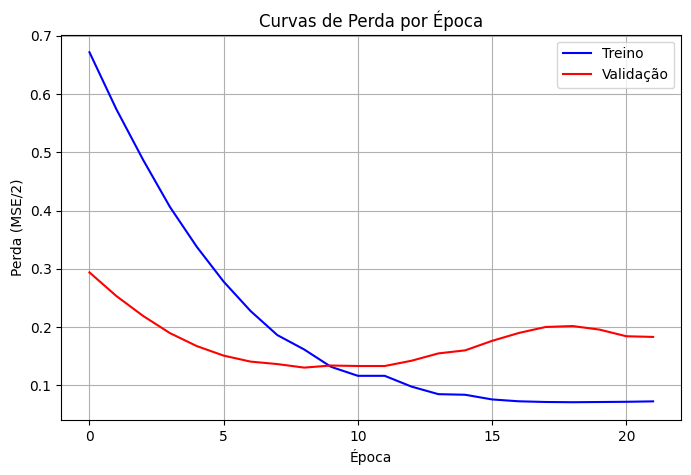

In [20]:
epocas = range(len(rede.perda_treino))  # número de épocas

plt.figure(figsize=(8,5))
plt.plot(epocas, rede.perda_treino, label="Treino", color='blue')
plt.plot(epocas, rede.perda_validacao, label="Validação", color='red')
plt.xlabel("Época")
plt.ylabel("Perda (MSE/2)")
plt.title("Curvas de Perda por Época")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
df = pd.read_excel("2018 Cruz Neto Polar wide.xlsx")
df = df.drop(columns=df.columns[0])
df = df.melt(id_vars=["Sample", "Pot (kW)", "Speed (mm/s)", "Thickness (mm)"],
             var_name="Theta (°)",
             value_name="Radius (mm)")

grupos = df.groupby("Sample")
grupos.get_group("2T-01")

,Sample,Pot (kW),Speed (mm/s),Thickness (mm),Theta (°),Radius (mm)
0,2T-01,4.053,6.67,6.3,0,4.211640
24,2T-01,4.053,6.67,6.3,1,4.150367
48,2T-01,4.053,6.67,6.3,2,4.029631
72,2T-01,4.053,6.67,6.3,3,3.791549
96,2T-01,4.053,6.67,6.3,4,3.721391
...,...,...,...,...,...,...
8544,2T-01,4.053,6.67,6.3,356,3.130822
8568,2T-01,4.053,6.67,6.3,357,3.319888
8592,2T-01,4.053,6.67,6.3,358,3.567133
8616,2T-01,4.053,6.67,6.3,359,4.083982


In [16]:
df_normalizado = df.copy()
df_normalizado[["Pot (kW)", "Speed (mm/s)", "Thickness (mm)", "Theta (°)", "Radius (mm)"]] = StandardScaler().fit_transform(df_normalizado[["Pot (kW)", "Speed (mm/s)", "Thickness (mm)", "Theta (°)", "Radius (mm)"]])
print(df_normalizado.drop(columns="Sample").min(), "\n")
print(df_normalizado.drop(columns="Sample").max())

Pot (kW)         -1.921290
Speed (mm/s)     -1.300740
Thickness (mm)   -1.364248
Theta (°)        -1.727260
Radius (mm)      -1.614410
dtype: float64 

Pot (kW)          1.364187
Speed (mm/s)      1.421644
Thickness (mm)    1.376163
Theta (°)         1.727260
Radius (mm)       3.977823
dtype: float64


In [17]:
df_normalizado

,Sample,Pot (kW),Speed (mm/s),Thickness (mm),Theta (°),Radius (mm)
0,2T-01,1.195628,1.421644,-0.069503,-1.72726,3.209628
1,2T-03,0.361403,0.052301,-0.053617,-1.72726,2.514594
2,2T-05,1.295621,0.052301,-1.332475,-1.72726,2.697498
3,2T-06,0.364259,-1.300740,-1.364248,-1.72726,2.880401
4,2T-07,1.364187,0.052301,1.264958,-1.72726,3.465693
...,...,...,...,...,...,...
8659,2C-11,-0.144275,-1.300740,1.352333,1.72726,3.099886
8660,2C-12,-0.178559,1.421644,1.376163,1.72726,2.148787
8661,2C-13,-0.455681,0.052301,-0.013901,1.72726,2.551175
8662,2C-14,-0.481394,0.052301,-0.045674,1.72726,2.697498
